--- DEBUGGING INFO ---
Loaded 19 3D points.
First 3D point in UE coords (X,Y,Z): [ 1627.8719842  -1029.34948538   173.97795275]
First 3D point in CV coords (X,Y,Z): [-1029.34948538  -173.97795275  1627.8719842 ]

Projection Matrix (P):
[[    -960.          0.       2828.28 -5388218.  ]
 [    -540.       2828.28       -0.    -199054.53]
 [      -1.          0.         -0.       -840.  ]]

Found 19 points in front of the camera (out of 19 total).

First 5 VISIBLE projected (x, y) coordinates:
[[1077 -714]
 [1107 -753]
 [1108 -710]
 [1087 -692]
 [ 841 -714]]
----------------------



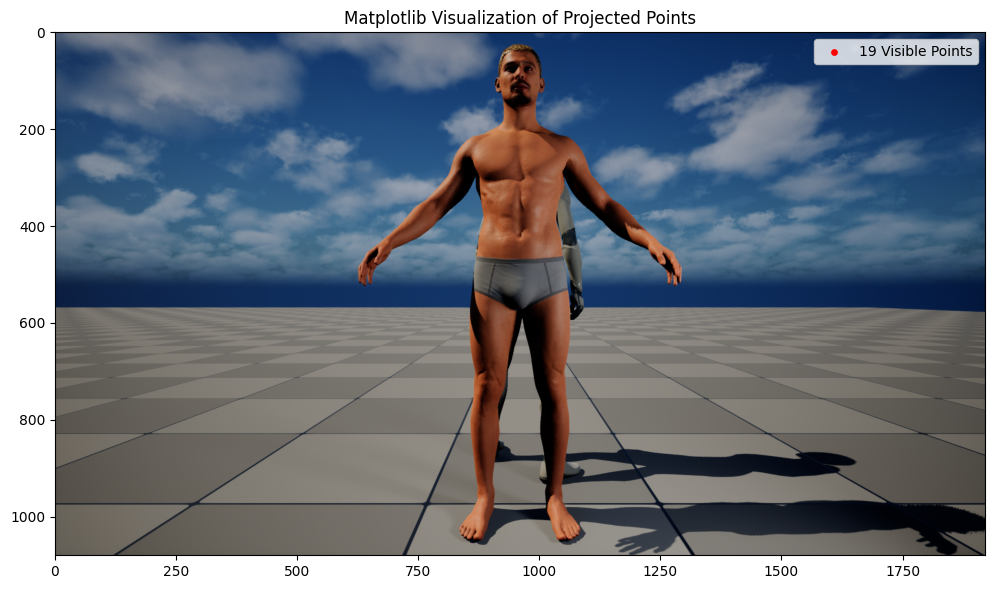

In [1]:
import numpy as np
import json
import cv2 as cv
import os
import matplotlib.pyplot as plt

# --- (Functions from before are unchanged) ---

def create_bone_array(bone_data):
    just_bones = []
    for item in bone_data:
        location = item['WorldLocation']
        x, y, z = location['X'], location['Y'], location['Z']
        just_bones.append([x, y, z])
    return np.array(just_bones)

def load_camera_parameters(intrinsic_path, extrinsic_path):
    with open(intrinsic_path, 'r') as f:
        intrinsic_data = json.load(f)
    with open(extrinsic_path, 'r') as f:
        extrinsic_data = json.load(f)
    K = np.array(intrinsic_data['Intrinsics']['IntrinsicMatrix'])
    extrinsic_cv_4x4 = np.array(extrinsic_data['Extrinsics']['ExtrinsicMatrix_CV'])
    return K, extrinsic_cv_4x4

def convert_ue_points_to_cv(points_ue):
    points_cv = np.zeros_like(points_ue)
    points_cv[:, 0] =  points_ue[:, 1]
    points_cv[:, 1] = -points_ue[:, 2]
    points_cv[:, 2] =  points_ue[:, 0]
    return points_cv

# --- MODIFIED project_points function ---
def project_points(points_3d, projection_matrix):
    """
    Projects 3D points to 2D and ALSO returns the depth values (w).
    """
    points_3d_homo = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    points_2d_homo = (projection_matrix @ points_3d_homo.T).T
    
    w = points_2d_homo[:, 2]
    # Set a small epsilon for w values that are exactly zero to avoid division errors
    w[w == 0] = 1e-6 
    
    points_2d = points_2d_homo[:, :2] / w[:, np.newaxis]
    
    # Return both the 2D points and their original depth values (w)
    return points_2d.astype(int), w

# --- MAIN WORKFLOW ---

if __name__ == "__main__":
    # Define file paths
    saved_path = "C:/Users/20716400/Documents/Unreal Projects/ExtractJointLocation/Saved"
    camera_name = "CineCameraActor_0"
    
    intrinsic_path = os.path.join(saved_path, "CameraData", camera_name, f"Intrinsics_{camera_name}.json")
    extrinsic_path = os.path.join(saved_path, "CameraData", camera_name, f"Extrinsics_{camera_name}.json")
    face_subset_path = os.path.join(saved_path, "FaceSubset", "BP_Carl_C_1_FaceSubset_BoneLocations.json")
    image_path = os.path.join(saved_path, "CameraFrames", "Camera1_Frame.png")

    # --- Load Data ---
    intrinsic_matrix, extrinsic_matrix_cv = load_camera_parameters(intrinsic_path, extrinsic_path)
    with open(face_subset_path, 'r') as f:
        face_keypoints = json.load(f)['Keypoints']
    face_bones_ue = create_bone_array(face_keypoints)
    image_bgr = cv.imread(image_path)
    
    # --- Create Projection Matrix ---
    extrinsic_3x4 = extrinsic_matrix_cv.T[:3, :]
    projection_matrix = intrinsic_matrix @ extrinsic_3x4
    
    # --- Convert 3D points ---
    face_bones_cv = convert_ue_points_to_cv(face_bones_ue)
    
    # --- Project Points and get depth values (w) ---
    projected_2d_points, w_values = project_points(face_bones_cv, projection_matrix)

    # --- DEBUGGING PRINTS ---
    print("--- DEBUGGING INFO ---")
    print(f"Loaded {len(face_bones_ue)} 3D points.")
    print("First 3D point in UE coords (X,Y,Z):", face_bones_ue[0])
    print("First 3D point in CV coords (X,Y,Z):", face_bones_cv[0])
    print("\nProjection Matrix (P):")
    np.set_printoptions(suppress=True, precision=2)
    print(projection_matrix)
    
    # --- CRITICAL FILTERING STEP ---
    # Keep only the points that are IN FRONT of the camera (where w > 0)
    visible_points_mask = w_values > 0
    visible_points_2d = projected_2d_points[visible_points_mask]
    
    print(f"\nFound {len(visible_points_2d)} points in front of the camera (out of {len(projected_2d_points)} total).")
    if len(visible_points_2d) > 0:
        print("\nFirst 5 VISIBLE projected (x, y) coordinates:")
        print(visible_points_2d[:5])
    print("----------------------\n")

    # --- Visualize with Matplotlib ---
    image_rgb = cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image_rgb)
    
    # ONLY plot the points that are visible
    if len(visible_points_2d) > 0:
        ax.scatter(visible_points_2d[:, 0], visible_points_2d[:, 1], c='red', s=15, label=f'{len(visible_points_2d)} Visible Points')
        ax.legend()

    height, width, _ = image_rgb.shape
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)
    ax.set_title("Matplotlib Visualization of Projected Points")
    plt.show()